In [49]:
import numpy as np
import pandas as pd
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn.metrics import silhouette_score

In [50]:
class AGNES(object):


    def __init__(self, cluster_count):
        self.cluster_count = cluster_count
        self.cluster_item_counts = np.array([])
        self.labels = np.array([])
        self.centroids = []

    def fit(self, data):
        if type(data) is not np.ndarray:
            data = np.array(data)

        self.cluster_item_counts = np.append(
            self.cluster_item_counts, np.ones(data.shape[0])
        )
        self.labels = np.append(
            self.labels, [len(self.centroids) + x for x in range(len(data))]
        )
        self.centroids += [d for d in data]

        while len(self.cluster_item_counts) != self.cluster_count:
            min_distance = np.inf
            i1, i2 = (0, 0)
            for i in range(len(self.cluster_item_counts)):
                distances = np.linalg.norm(self.centroids - self.centroids[i], axis=1)
                distances[distances == 0] = np.inf
                min_dist = np.min(distances)
                if min_dist < min_distance:
                    min_distance = min_dist
                    i1, i2 = i, np.argmin(distances)

            if i2 < i1:
                i1, i2 = i2, i1
            new_centroid = self.weigted_average(
                self.centroids[i1],
                self.centroids[i2],
                self.cluster_item_counts[i1],
                self.cluster_item_counts[i2],
            )
            self.centroids[i1] = new_centroid
            self.cluster_item_counts[i1] += self.cluster_item_counts[i2]
            self.cluster_item_counts = np.delete(self.cluster_item_counts, i2)
            del self.centroids[i2]
            self.labels[self.labels == i2] = i1
            self.labels[self.labels > i2] -= 1

        return np.array(self.centroids), self.labels

    def weigted_average(self, centroid1, centroid2, weight1, weight2):
        c_size = len(centroid1)
        new_centroid = np.zeros((c_size))
        for i in range(c_size):
            new_centroid[i] = np.average(
                [centroid1[i], centroid2[i]], weights=[weight1, weight2]
            )
        return np.array(new_centroid)

In [51]:
class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()
     # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()

In [52]:
def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)

(300, 2)


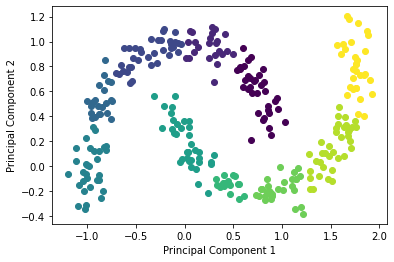

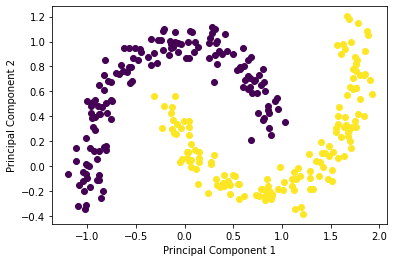

In [53]:
def main():
    # Load the dataset
    X, y = datasets.make_moons(n_samples=300, noise=0.08, shuffle=False)
    print(X.shape)
    # Cluster the data using Agnes
    agnes_cluster = AGNES(10)
    centroids, labels = agnes_cluster.fit(X)
    p = Plot()
    p.plot_in_2d(X, labels)
    p.plot_in_2d(X, y)


if __name__ == "__main__":
    main()